In [1]:
from importlib import reload
from os.path import join
from collections import defaultdict
import sys
import os
import numpy as np
from matplotlib import pyplot
import cv2
cv2.setNumThreads(1)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as tf
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [3]:
from datasets.dshdf5pose import Hdf5PoseDataset
import datatransformation
import neuralnets.models
import vis
import utils
import train

In [4]:
net = neuralnets.models.LocalizerNet()
net.cuda()

LocalizerNet(
  (initial_stage): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convnet): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    )
    (2): _InvertedResidual(
      (layers): Sequential(
        (0): Conv2d(8, 16, kernel_size=(1, 1), str

In [5]:
# Adjust as needed
path = join(os.environ['DATADIR'],'widerfacessingle.h5')

h, w = net.input_resolution
augh = round(h*1.2)
augw = round(w*1.2)

trainset = Hdf5PoseDataset(
        path,
        shuffle = True,
        subset = slice(500,None),
        transform=transforms.Compose([
            datatransformation.RescaleMaintainAspect((augh, augw)),
            datatransformation.RandomCrop(net.input_resolution),
            datatransformation.AdaptiveBrightnessContrastDistortion(),
            datatransformation.ImageColorDistort(),
            datatransformation.Flip(),
            datatransformation.Normalize(monochrome=True),
            datatransformation.ToTensor(),
]))


testset = Hdf5PoseDataset(
        path,
        shuffle = False,
        subset = slice(500),
        transform=transforms.Compose([
            datatransformation.RescaleMaintainAspect(net.input_resolution),
            datatransformation.Normalize(monochrome=True),
            datatransformation.ToTensor(),
]))

In [6]:
train_loader = datatransformation.PostprocessingDataLoader(trainset, 
                          batch_size=32,
                          shuffle=False, 
                          num_workers=5,
                          postprocess = transforms.Compose([
                                datatransformation.BlurNoiseDistortion(),
                          ]))
test_loader = DataLoader(testset, 
                          batch_size=32,
                          shuffle=False, 
                          num_workers=5)

In [7]:
def iterate_loader(loader):
    for batch in loader:
        for sample in utils.undo_collate(batch):
            yield vis.unnormalize_sample_to_numpy(sample)

%matplotlib notebook
vis.matplotlib_plot_iterable(iterate_loader(train_loader), vis.draw_dataset_sample)

<IPython.core.display.Javascript object>

(<Figure size 1000x1000 with 10 Axes>,
 <matplotlib.widgets.Button at 0x7f7b2424e1d0>)

In [8]:
%matplotlib inline

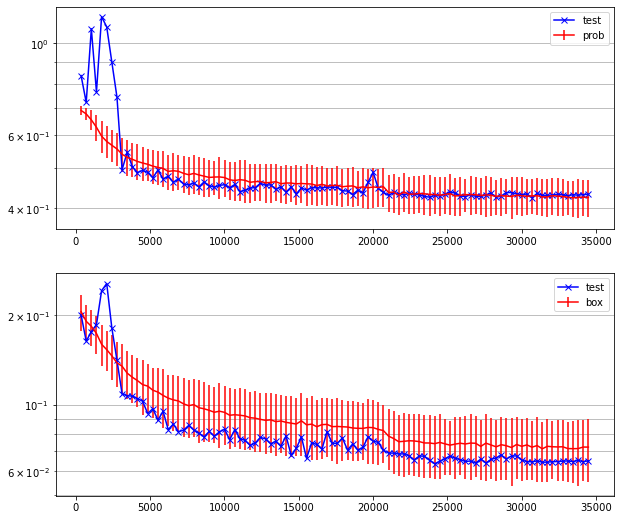

Finished Training


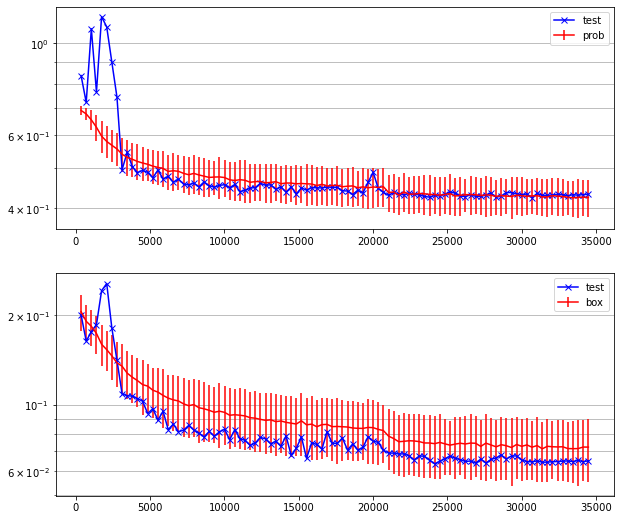

In [9]:
n_epochs = 100
optimizer = optim.Adam(net.parameters(), lr=1.e-3, weight_decay=1.e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [60,90], gamma=0.1)

criterions = [
    train.LocalizerProbLoss(),
    train.LocalizerBoxLoss(),
]
critweights = np.array([0.1, 1.])

train.run_the_training(
    n_epochs,
    optimizer,
    net,
    train_loader,
    test_loader,
    criterions,
    critweights,
    2,
    join('..','model_files'),
    None,
    [],
    scheduler)